In [ ]:

!pip install python-chess
import chess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 55.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=d2d783a88578dca5cc5f7842f842cd408ea66fc2e6da84b068358cc099fddaa8
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [ ]:
def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_piece(piece))
        board_list.append(row_list)
    return np.array(board_list)

def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/chess/train.csv', index_col='id')
# We'll only use the first 10000 examples so things run fast,
# but you'll get better performance if you remove this line
train_df = train_df[:25000]

# We'll also grab the last 1000 examples as a validation set
val_df = train_df[-1000:]
train_df.head()

def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

# We'll stack all our encoded boards into a single numpy array
X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']


X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# With the Keras Sequential model we can stack neural network layers together
model = Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1),
])

model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error')

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_data=(X_val, y_val))

model.save('chess_model.h5')


Epoch 1/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 160718.2500 - val_loss: 146535.0938
Epoch 2/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 143723.3750 - val_loss: 138197.5156
Epoch 3/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 134985.9531 - val_loss: 131375.1094
Epoch 4/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 132439.7344 - val_loss: 128336.2344
Epoch 5/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 127004.5391 - val_loss: 121295.0703
Epoch 6/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 122824.3828 - val_loss: 117975.8516
Epoch 7/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 120403.1250 - val_loss: 113754.7031
Epoch 8/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 116572.6719 - val_loss: 110941.5391
Epoch 9/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 116875.1250 - val_loss: 110308.0234
Epoch 10/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 115369.0312 - val_loss: 107060.5938
Epoch 11/200
782/782 ━━━━━━━━

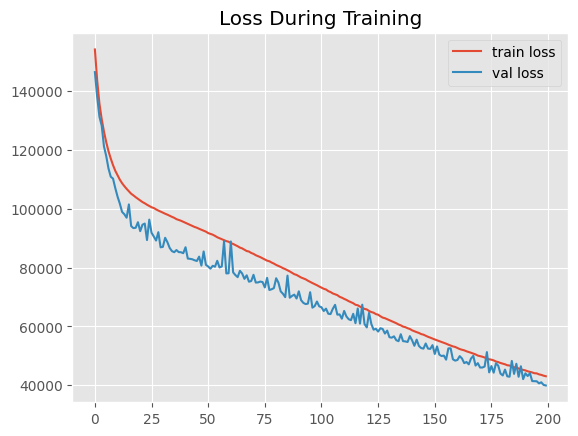

In [ ]:
# Plotting our latest training results
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

In [ ]:
# Implementing our model as a function
def play_nn(fen, show_move_evaluations=False):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then evaluate all legal moves
    moves = []
    input_vectors = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        moves.append(move)
        input_vectors.append(encode_board(str(candidate_board)).astype(np.int32))

    input_vectors = np.stack(input_vectors)
    # This is where our model gets to shine! It tells us how good the resultant score board is for black:
    scores = model.predict(input_vectors, verbose=0)
    # argmax gives us the index of the highest scoring move
    if board.turn == chess.BLACK:
        index_of_best_move = np.argmax(scores)
    else:
        # If we're playing as white, we want black's score to be as small as possible, so we take argmax of the negative of our array
        index_of_best_move = np.argmax(-scores)

    if show_move_evaluations:
        print(zip(moves, scores))

    best_move = moves[index_of_best_move]

    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [ ]:
# Now we'll import our test set, and make some final predictions!

test_df = pd.read_csv('/content/drive/MyDrive/chess/test.csv')

test_df.head()

,id,board
0,7937,r1bqk2r/pp2bpp1/2n1pn1p/2pp4/3P1B2/2P1PN2/PP1N...
1,20035,2r2k1r/pp2pp1p/1q3npb/1B1N4/8/P4Q1P/1P3PP1/R2R...
2,71263,3b4/8/5k2/5p2/8/4K3/8/5B2 b - - 2 80
3,61997,5k2/R7/3r3p/2PP2pP/5pb1/P1K5/6B1/8 w - - 1 61
4,26510,r3r1k1/pb3p1p/1p1q2p1/3P1p2/3Q1P2/5N2/PP4PP/3R...


In [ ]:
# Making all of our predictions happens in this one line!
# We're basically saying "run play_nn on all the boards in the test_df, and then keep the results as best_move"
# Because this invovles running our model a _ton_ this step will take a while.

test_df['best_move'] = test_df['board'].apply(play_nn)

In [ ]:
test_df['best_move']

,best_move
0,c5d4
1,d5b6
2,f6f7
3,c5d6
4,e8e1
...,...
195,b4b2
196,f6f5
197,c7c8r
198,h2g1


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


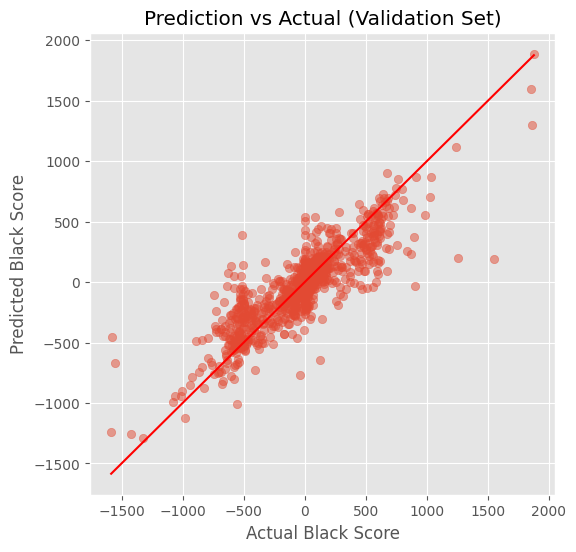

In [ ]:
y_val_pred = model.predict(X_val).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.xlabel("Actual Black Score")
plt.ylabel("Predicted Black Score")
plt.title("Prediction vs Actual (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red')  # Line y = x
plt.grid(True)
plt.show()


In [ ]:
!pip install python-chess
import random
import chess


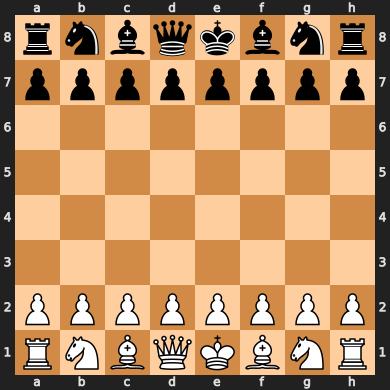

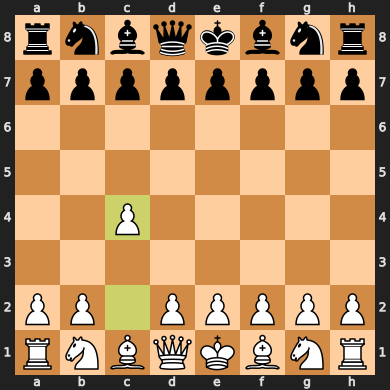

AI move: g8f6


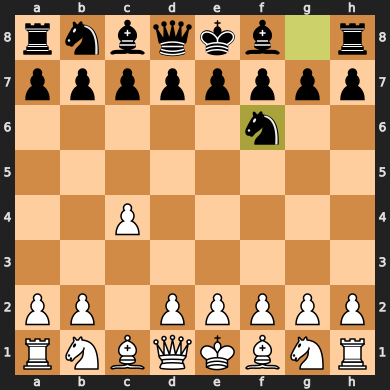

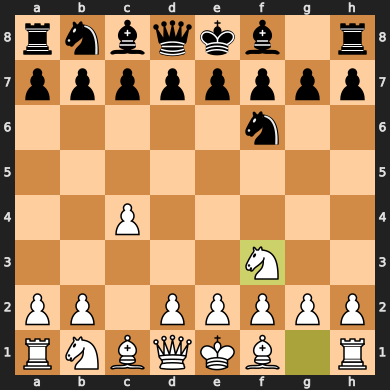

AI move: c7c5


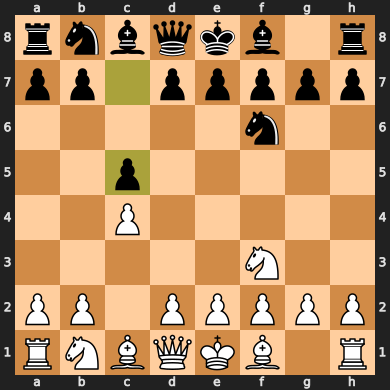

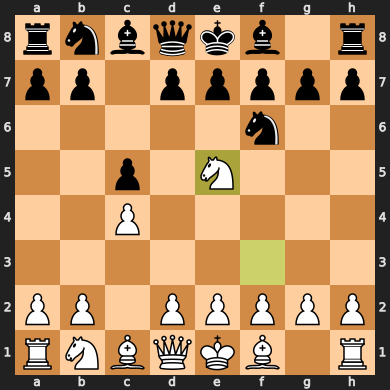

AI move: d7d5


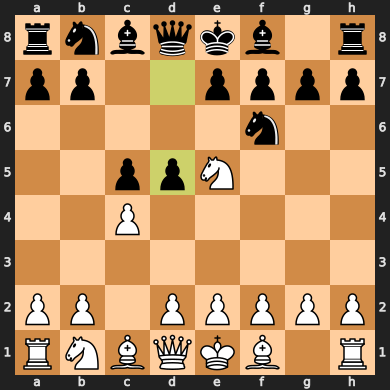

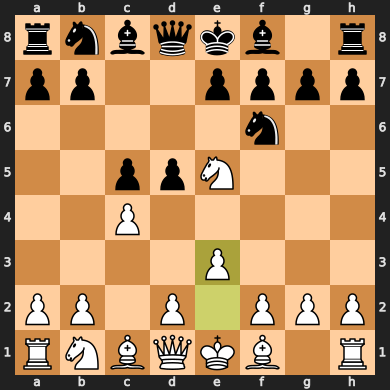

AI move: d5d4


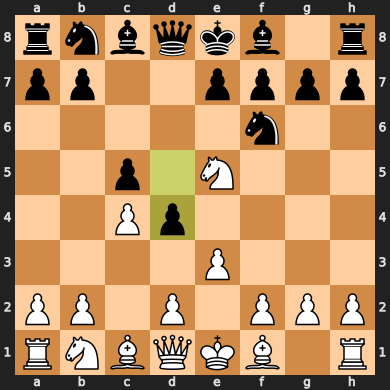

That wasn't a valid move. Please enter a move in Standard Algebraic Notation


In [ ]:
import sys
import time
from IPython.display import SVG, display
import chess
import random

# Random AI function (required for the game to run)
def play_random(fen):
    board = chess.Board(fen)
    move = random.choice(list(board.legal_moves))
    return board.san(move)

# Game loop
def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        display(SVG(board._repr_svg_()))
        sys.stdout.flush()   # ✅ forces output to flush
        time.sleep(0.1)       # ✅ gives the notebook a moment to render

        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)

    print(board.outcome())

# Run the game
play_game(play_nn)


In [ ]:
from google.colab import files
files.download('chess_model.h5')